In [460]:
import tensorflow as tf
import os, glob
import numpy as np
import matplotlib.pyplot as plt

from models import *
from tSNE_plot import *

In [563]:
load_dir = 'train_result/train_5/'

In [564]:
x_test = np.load('%s/x_test.npy'%(load_dir))
x_info = np.load('%s/y_test.npy'%(load_dir))
x_name = np.load('./data/w58y67/preprocessing_2/step_1/wav_name.npy')
print('* data shape: ', x_test.shape)
print('* data shape: ', x_info.shape)
print('* data shape: ', x_name.shape)

* data shape:  (5173, 128, 64, 1)
* data shape:  (5173, 3)
* data shape:  (3210,)


In [4]:
encoder, decoder, vae = build_vae(x_test, 10)

In [5]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 1)]      0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  361396    
_________________________________________________________________
decoder (Model)              (None, 128, 64, 1)        359809    
Total params: 721,205
Trainable params: 721,205
Non-trainable params: 0
_________________________________________________________________


In [6]:
ckp_dir = load_dir+'/ckp/'
checkpoint = tf.train.Checkpoint(step=tf.Variable(1), encoder=encoder, decoder=decoder, vae=vae)
checkpoint.restore(tf.train.latest_checkpoint(ckp_dir))

In [7]:
x_input = x_test/255
x_rec = vae.predict(x_input)
z_lat = encoder.predict(x_input)[2]

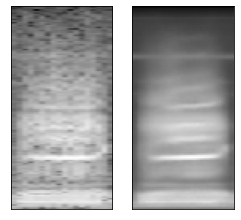

In [8]:
plot_recimg(6, x_test, x_rec)

In [569]:
import umap
umap = UMAP(random_state=456)
#pipeline = Pipeline([("umap", umap),
#                     ("svc", svc)])
#params_grid_pipeline = {"umap__n_neighbors": [5, 20],
#                        "umap__n_components": [15, 25, 50],
#                        "svc__C": [10**k for k in range(-3, 4)]}

#clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
#clf_pipeline.fit(X_train, y_train)
#print("Accuracy on the test set with UMAP transformation: {:.3f}".format(
#    clf_pipeline.score(X_test, y_test)))

ModuleNotFoundError: No module named 'umap'

In [259]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,
#perplexity=20, early_exaggeration=12.0,
   #learning_rate=200.0, n_iter=300, n_iter_without_progress=300,
     min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
#     random_state=None, method='barnes_hut', angle=0.5
           )
tsne_val = tsne.fit_transform(z_lat)
tsne_val.shape

(5173, 2)

In [261]:
from sklearn.cluster import KMeans

n_cluster=15

model = KMeans(init="k-means++", n_clusters=n_cluster, random_state=0, max_iter = 5
#model = KMeans(n_clusters=n_cluster, init="k-means++", 
#               n_init=100, max_iter=100, tol=0.00001, 
#            precompute_distances=’auto’,)
#           verbose=0, random_state=None, copy_x=True, 
               #, algorithm=’auto’)
              )
model.fit(tsne_val)
y_pred = model.labels_

-73.11449432373047 71.7082748413086 -64.84007263183594 75.13594055175781


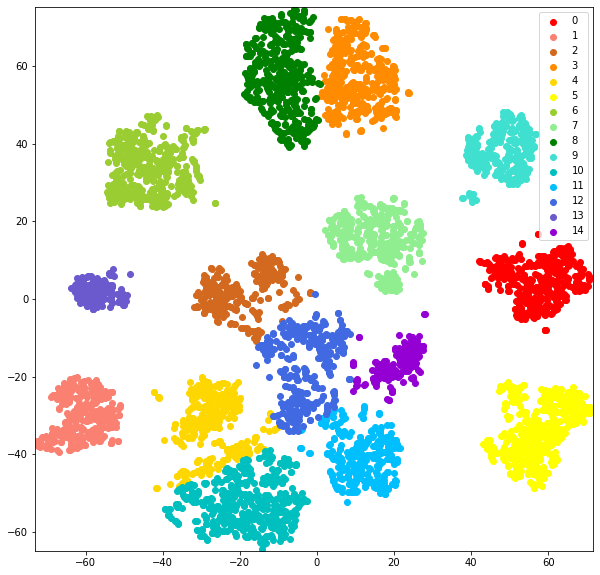

In [308]:
plot_scatter(tsne_val, y_pred, save='%s/%s'%(load_dir, 'scatter'))

In [536]:
def get_val(wav_info, wav_name, idx):
    wav_name = wav_name[wav_info[idx][0]]
    start=wav_info[idx][1]
    lenth=wav_info[idx][2]
    end = start+lenth

    wav_path = 'data/w58y67/org/'+wav_name.split('_')[1]
    wav_file = wav_path+'/'+wav_name+'.wav'
    
    x, y = wavfile.read(wav_file)
    val = y[:,0][start:end]
    
    return lenth, val

def plot_group_wav(wav_info, wav_name, y_data, gidx, save=None):

    x, y = 5, 10
    fig = plt.figure(figsize=(y,x*2))

    cond = y_data == gidx
    g_info = wav_info[cond]
    print(g_info.shape)
    for i in range(x):
        for j in range(y):
            idx = i*y+j
            lenth, val = get_val(g_info, wav_name, idx)
            plt.subplot(x, y, idx+1)
            
            plt.xticks([0,  lenth-lenth%1000])
            plt.yticks([])
            plt.plot(val)
    fig.suptitle('Group %s'%(str(gidx)), fontsize=30)
    if save != None:
        plt.savefig(save+'gwav_%s'%(str(gidx)))
    plt.show()

-73.11449432373047 71.7082748413086 -64.84007263183594 75.13594055175781


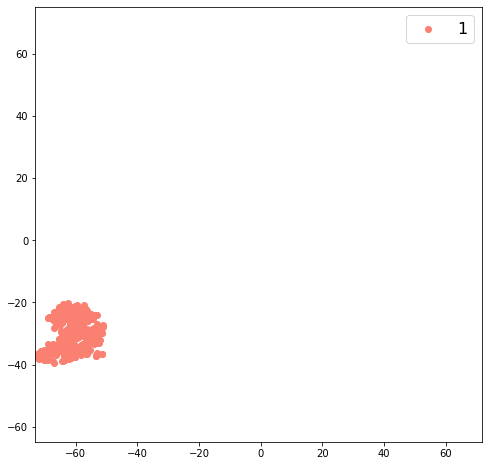

(319, 3)


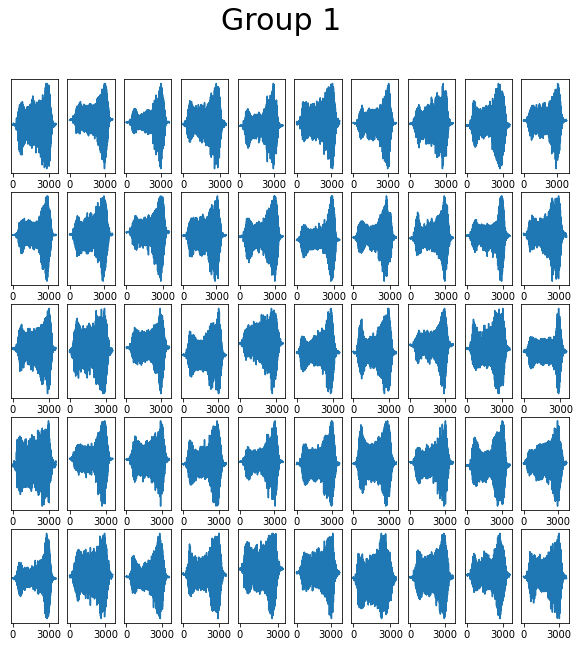

In [556]:
idx = 1
good_id=[0,1,3,5,6,7,8,9,13]
bad_id = [2,4,10,11,12,14]
plot_scatter(tsne_val, y_pred, idx, size =8)
#plot_group(x_test, y_pred, idx, load_dir)
plot_group_wav(x_info, x_name, y_pred, idx, load_dir)

In [377]:


def draw_lenth(groups, save_dir=None):
    for i in groups:
        cond = y_pred==i
        gx = x_test[cond]
        gy = y_test[cond]
        plt.hist(gy[:,2], range=(0,6000), color = c_list[i], bins=50, alpha=0.7)
    #plt.title( '%i: %i'%(idx, len(gx)))
    plt.yticks([0,700])
    
    if save_dir != None:
        plt.savefig(save_dir)
    plt.show()

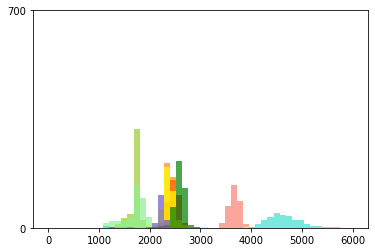

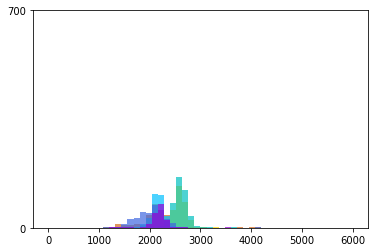

In [379]:
draw_lenth(good_id)
draw_lenth(bad_id)

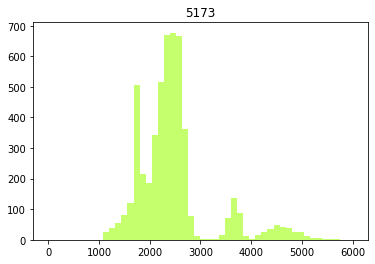

In [365]:
plt.title( len(y_test))
plt.hist(y_test[:,2], range=(0,6000), bins=50, color = c_base, alpha=0.7)
plt.savefig('%s/lenth'%load_dir)
plt.show()

In [535]:
433%100

33